In [3]:
import numpy as np
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d
from src.nflow_utils import *
import os
from matplotlib import colors
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *
import pickle
from scipy.stats import rv_histogram


In [7]:
cd ..

/scratch/rd804/m-anode


In [9]:
cuts = {}

for sig in nsigs:
    
   # if sig != 1000:
    #    continue
    if sig == 1000:
       cuts[sig] = 10**(-np.array([2.7,2.7,2.7,2.7,2.7,2.7,2.7,
                                   2.7,2.7,2.7]))
      #cuts[sig] = [0.0038,0.0032,0.003,0.003,0.0035,0.0038,
               #  0.004,0.003, 0.0036, 0.003]
    if sig == 600:
      cuts[sig] = 10**(-np.array([3.0,3.6,3.6,3.0,3.0,3.0,3.0,
                                  3.0,3.5,3.5 ]))
    if sig == 500:
      cuts[sig] = 10**(-np.array([4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
                                  4.0, 4.0, 4.0 ]))
    if sig == 450:
      cuts[sig] = 10**(-np.array([3.3,3.3,3.3,3.3,3.3,3.3,3.3,
                                  3.3,3.3,4.0]))
    if sig == 300:
      cuts[sig] = 10**(-np.array([3.7,3.7,3.7,3.7,3.7,3.7,3.7,
                                  3.7,3.7,3.7 ]))
    if sig == 225:
      cuts[sig] = 10**(-np.array([4.0,4.0,4.0,4.0,4.0,4.0,4.0,
                                  4.0,4.0,4.0 ]))
    if sig == 150:
      cuts[sig] = 10**(-np.array([4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
                                  4.0, 4.0, 4.0 ]))
    if sig == 75:
      cuts[sig] = 10**(-np.array([4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
                                  4.0, 4.0, 4.0 ]))
      
    if sig == 0:
       cuts[sig] = 10**(-np.array([4.2]))

In [13]:
wandb_group_BDT = "BDT"
wandb_project_BDT = "supervised"
wandb_job_type_BDT = "sample"

wandb_group_BDT_50 = "BDT"
wandb_project_BDT_50 = "IAD_weighted_50"
#wandb_project_BDT_50 = "IAD_mass_50"
wandb_job_type_BDT_50 = "sample"

wandb_group_anode = "nflows_lhc_co_nsig_scan"
wandb_project_anode = "anode_SR_RQS"
wandb_job_type_anode = "try"

wandb_group_ranode_learned = "nflows_lhco"
wandb_job_type_ranode_learned = "try"
wandb_project_ranode_learned = "joint_random"
#wandb_job_type_ranode_learned = "try"

wandb_group_ranode_pdata = "nflows_lhco"
wandb_job_type_ranode_pdata = "try"
wandb_project_ranode_pdata = "joint_pdata"
#wandb_group_ranode_true = "nflows_lhc_co_nsig_scan"
#wandb_project_ranode_true = "ra_mass_joint_un_clip"
#wandb_job_type_ranode_true = "try"


data_dir = "data/lhc_co"

mask = np.load(f'results/{wandb_group_BDT_50}/{wandb_project_BDT_50}_{1000}/{wandb_job_type_BDT_50}_{0}/mask_test.npy')
labels = np.load(f'{data_dir}/x_test.npy')[mask][:,-1]

#############################
CR_path = 'results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0'
SR_data, CR_data , true_w, sigma = resample_split(data_dir, n_sig = 500, resample_seed = 1,resample = True)

with open(f'{CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters_CR = pickle.load(f)

pre_parameters_SR_ = preprocess_params_fit_all(SR_data)

pre_parameters_SR = pre_parameters_CR.copy()
for key in pre_parameters_CR.keys():
    pre_parameters_SR[key]= np.insert(pre_parameters_CR[key], 0, pre_parameters_SR_[key][0])
_x_test = np.load(f'{data_dir}/x_test.npy')
_, mask_CR = logit_transform(_x_test[:,1:-1], pre_parameters_CR['min'],
                                pre_parameters_CR['max'])
_, mask_SR = logit_transform(_x_test[:,:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])
mask_joint = mask_CR & mask_SR 
labels_joint = _x_test[mask_joint][:,-1]

mass = np.load(f'{data_dir}/true_mass.npy')
labels_m = np.load(f'{data_dir}/true_labels.npy')

bins = np.linspace(3.3, 3.7, 50)
#hist_sig = np.histogram(mass[labels==1], bins=bins, density=True)
#density_sig = rv_histogram(hist_sig)

hist_back = np.histogram(mass[labels_m==0], bins=bins, density=True)
density_back = rv_histogram(hist_back)
#############################


#nsigs = [75,150,225,300,450,500,600,1000]
#nsigs = [1000,600,500,450,300,225,150,75]
#sigmas = [2.166,1.294,1.076,0.9714,0.6499,0.4866,0.3247,0.1521]
#nsigs = [1000,600,450,300,225,150]
#sigmas = [2.166,1.294,0.9714,0.6499,0.4866,0.3247]
nsigs = [1000,300]
sigmas = [2.166,0.9714]
#sigmas = [0.9714,0.4866]
#nsigs = [300]
#sigmas = [0.6499]
color = ['C0','C1','C2','C3','C4','C5','C6','C7']

#colors = []
_median_sic_IAD = []
_sic_min_IAD = []
_sic_max_IAD = []

_median_sic_IAD_50 = []
_sic_min_IAD_50 = []
_sic_max_IAD_50 = []

_median_sic_ANODE = []
_sic_min_ANODE = []
_sic_max_ANODE = []

_median_sic_ranode_learned = []
_sic_min_ranode_learned = []
_sic_max_ranode_learned = []

_median_sic_RANODE_pdata = []
_sic_min_RANODE_pdata = []
_sic_max_RANODE_pdata = []



choosing random 500 signal events for mock_data from 70000 events


sigma=1.0736139182873174
true w: 0.003072474245436472


[]

In [11]:
pwd

'/scratch/rd804/m-anode'

number of successful retrainings 15
initial ensemble_S shape (20, 366150)
final ensemble_S shape (15, 366150)
choosing random 1000 signal events for mock_data from 70000 events
sigma=2.118521582074974
true w: 0.0060447211073798015
number of successful retrainings 14
initial ensemble_S shape (20, 366150)
final ensemble_S shape (14, 366150)
choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1156509566250077
true w: 0.006036579872060546
number of successful retrainings 15
initial ensemble_S shape (20, 366150)
final ensemble_S shape (15, 366150)
choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1041684548251434
true w: 0.0060040135970839984
number of successful retrainings 13
initial ensemble_S shape (20, 366150)
final ensemble_S shape (13, 366150)
choosing random 1000 signal events for mock_data from 70000 events
sigma=2.2706647309231767
true w: 0.00647601581752536
number of successful retrainings 15
initial ensemble_S shape (20, 366150)
fi

number of successful retrainings 16
initial ensemble_S shape (20, 366150)
final ensemble_S shape (16, 366150)
number of successful retrainings 13
initial ensemble_S shape (20, 366150)
final ensemble_S shape (13, 366150)
number of successful retrainings 13
initial ensemble_S shape (20, 366150)
final ensemble_S shape (13, 366150)
(10000,)


/home/rd804/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rd804/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(10000,)


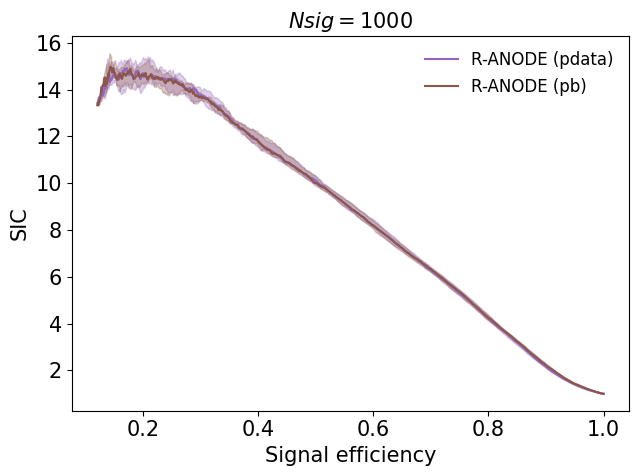

number of successful retrainings 16
initial ensemble_S shape (20, 366150)
final ensemble_S shape (16, 366150)
choosing random 300 signal events for mock_data from 70000 events
sigma=0.6171844717427092
true w: 0.0017685720631421356
number of successful retrainings 13
initial ensemble_S shape (20, 366150)
final ensemble_S shape (13, 366150)
choosing random 300 signal events for mock_data from 70000 events
sigma=0.6458907262423701
true w: 0.001850678993559637
number of successful retrainings 14
initial ensemble_S shape (20, 366150)
final ensemble_S shape (14, 366150)
choosing random 300 signal events for mock_data from 70000 events
sigma=0.6458907262423701
true w: 0.001850678993559637
number of successful retrainings 13
initial ensemble_S shape (20, 366150)
final ensemble_S shape (13, 366150)
choosing random 300 signal events for mock_data from 70000 events
sigma=0.6918207334418275
true w: 0.001982021991397531
number of successful retrainings 15
initial ensemble_S shape (20, 366150)
final

/home/rd804/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rd804/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(10000,)


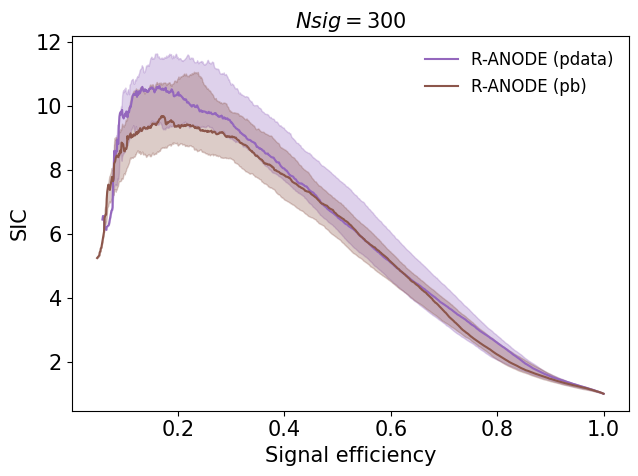

In [24]:


for k,nsig in enumerate(nsigs):
    

    tprs_ranode_learned = []
    fprs_ranode_learned = []

    tprs_ranode_pdata = []
    fprs_ranode_pdata = []

    tpr_interp = np.linspace(0.001, 1, 1000)


    # Unconditional

    for i in range(10):
        if i==0:
          ensemble_B = np.load(f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_{0}/ensemble_B.npy')
        path_ensemble_S = f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_'
 
        ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S_joint.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S.npy')]

        w_try = []
        for ensembles in range(20):
          valloss = np.load(f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_{ensembles}/valloss.npy')
          lowest_epochs = np.argsort(valloss)[0:10]
          w_ensemble = []
          for epoch in lowest_epochs:
            w_ = np.load(f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_{ensembles}/w_{epoch}.npy')
            w_ensemble.append(w_)
          w_ensemble = np.array(w_ensemble)
          w_median = np.median(w_ensemble, axis=0)
          w_try.append(w_median)
        
        w_try = np.array(w_try)
        fail_mask = (w_try > cuts[nsig][i])*1

        #fail_mask = (w_try > 0.0001)*1

       #print('number of retrainings remaining', np.sum(mask, axis=0))
        print('number of successful retrainings', np.sum(fail_mask))

        ensemble_S = np.array(ensemble_S)
        print('initial ensemble_S shape', ensemble_S.shape)
        ensemble_S = ensemble_S[fail_mask==1]
        print('final ensemble_S shape', ensemble_S.shape)

        ensemble_S = np.mean(ensemble_S, axis=0)
        assert ensemble_B.shape == ensemble_S.shape
        SR_data, CR_data , true_w, sigma = resample_split(data_dir, n_sig = nsig, resample_seed = i,resample = True)

        hist_data = np.histogram(SR_data[:,0], bins=bins, density=True)
        density_data = rv_histogram(hist_data)
      #  mask_joint = mask_CR & mask_SR 
       # labels_joint = _x_test[mask][:,-1]
        _x_test = np.load(f'{data_dir}/x_test.npy')

        mass_density = density_data.pdf(_x_test[mask][:,0])
      #  print('mass_density shape', mass_density.shape)
      # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)
        ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B*mass_density+1e-32)       

       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)

        tpr_cut, fpr_cut = roc_interp(labels, ypred, tpr_interp)
        tprs_ranode_pdata.append(tpr_cut)
        fprs_ranode_pdata.append(fpr_cut)


    for i in range(10):
        if i==0:
          ensemble_B = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{0}/ensemble_B.npy')
        path_ensemble_S = f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_'
 
        ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S_joint.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S.npy')]

        w_try = []
        for ensembles in range(20):
          valloss = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{ensembles}/valloss.npy')
          lowest_epochs = np.argsort(valloss)[0:10]
          w_ensemble = []
          for epoch in lowest_epochs:
            w_ = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{ensembles}/w_{epoch}.npy')
            w_ensemble.append(w_)
          w_ensemble = np.array(w_ensemble)
          w_median = np.median(w_ensemble, axis=0)
          w_try.append(w_median)
        
        w_try = np.array(w_try)
        fail_mask = (w_try > cuts[nsig][i])*1

       #print('number of retrainings remaining', np.sum(mask, axis=0))
        print('number of successful retrainings', np.sum(fail_mask))

        ensemble_S = np.array(ensemble_S)
        print('initial ensemble_S shape', ensemble_S.shape)
        ensemble_S = ensemble_S[fail_mask==1]
        print('final ensemble_S shape', ensemble_S.shape)

        ensemble_S = np.mean(ensemble_S, axis=0)
        assert ensemble_B.shape == ensemble_S.shape
        _x_test = np.load(f'{data_dir}/x_test.npy')

      #  mask_joint = mask_CR & mask_SR 
        labels_joint = _x_test[mask][:,-1]
        mass_density = density_back.pdf(_x_test[mask][:,0])
      #  print('mass_density shape', mass_density.shape)
       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)
        ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B*mass_density+1e-32)       

       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)

        tpr_cut, fpr_cut = roc_interp(labels, ypred, tpr_interp)
        tprs_ranode_learned.append(tpr_cut)
        fprs_ranode_learned.append(fpr_cut)

    # print('tpr_cut shape', tpr_cut.shape)
   # sic_median_BDT, tpr_cut_BDT = SIC_cut_(tprs_BDT,fprs_BDT)

    sic_median_ranode_learned , sic_max_ranode_learned, sic_min_ranode_learned, tpr_cut_ranode_learned = \
    ensembled_SIC(tprs_ranode_learned, fprs_ranode_learned)
    sic_median_ranode_pdata , sic_max_ranode_pdata, sic_min_ranode_pdata, tpr_cut_ranode_pdata = \
    ensembled_SIC(tprs_ranode_pdata, fprs_ranode_pdata)


    index = np.argmax(sic_median_ranode_learned)
    _median_sic_ranode_learned.append(sic_median_ranode_learned[index])
    _sic_min_ranode_learned.append(sic_min_ranode_learned[index])
    _sic_max_ranode_learned.append(sic_max_ranode_learned[index])

    index = np.argmax(sic_median_ranode_pdata)
    _median_sic_RANODE_pdata.append(sic_median_ranode_pdata[index])
    _sic_min_RANODE_pdata.append(sic_min_ranode_pdata[index])
    _sic_max_RANODE_pdata.append(sic_max_ranode_pdata[index])


   # plt.plot(tpr_cut_ranode_learned, sic_median_ranode_learned, color='C3', linestyle='-', label='R-ANODE conditional')
    plt.plot(tpr_cut_ranode_pdata, sic_median_ranode_pdata, color='C4', linestyle='-',label='R-ANODE (pdata)')
    plt.fill_between(tpr_cut_ranode_pdata, sic_min_ranode_pdata, sic_max_ranode_pdata, alpha=0.3, color='C4')

    plt.plot(tpr_cut_ranode_learned, sic_median_ranode_learned, color='C5', linestyle='-', label='R-ANODE (pb)')
    plt.fill_between(tpr_cut_ranode_learned, sic_min_ranode_learned, sic_max_ranode_learned, alpha=0.3, color='C5')
    #plt.plot(tpr_cut_BDT, sic_median_BDT, color='C2', linestyle='-',label='IAD-BDT')
    plt.xlabel('Signal efficiency',fontsize=15)
    plt.ylabel('SIC',fontsize=15)
    plt.title(f'$Nsig={nsig}$', fontsize=15)
    plt.legend(loc='upper right', frameon=False, fontsize=12)
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./figures/presentation/SIC_curves_pdata_pbm_{nsig}.pdf',dpi=200)
    #plt.colorbar()
   # plt.savefig(f'./figures/presentation/SIC_curves_mass_supervised_2_{nsig}.pdf',dpi=200)
    plt.show()

    ###################################
    ###################################


[14.920442352691827,
 10.62362847787554,
 14.920442352691827,
 10.62362847787554,
 14.920442352691827,
 10.62362847787554]

In [23]:
_sic_max_RANODE_pdata

[14.17018521472489,
 9.457540967415456,
 14.17018521472489,
 9.457540967415456,
 14.17018521472489,
 9.457540967415456]

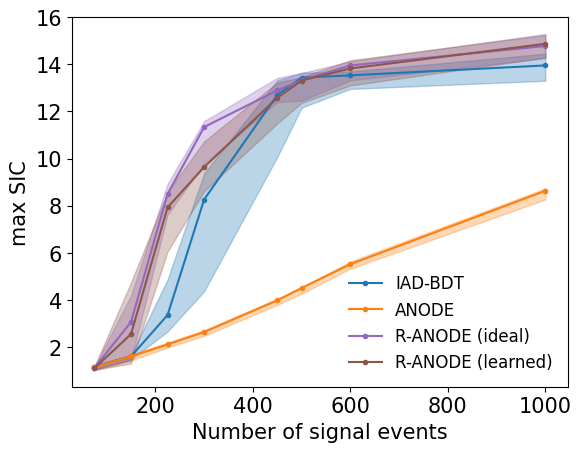

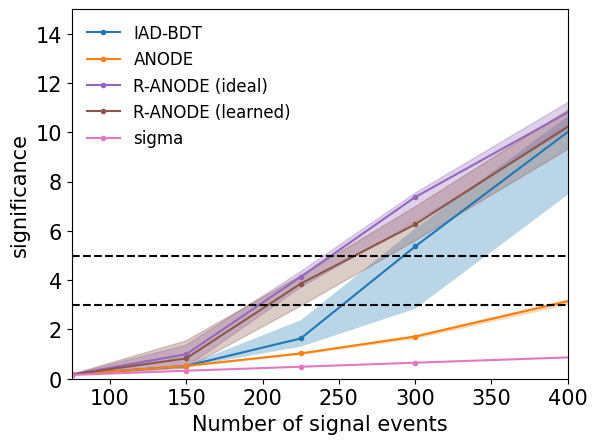

In [9]:


#plt.plot(tpr_cut_BDT, tpr_cut_BDT**0.5, color='black',label='')
#plt.plot([],[], ls = '-', label='ANODE',color='black')
#plt.plot([],[], ls = '--', label='IAD-BDT',color='black')
#plt.plot([],[], ls = '-.', label='R-ANODE conditional',color='black')
#plt.plot([],[], ls = ':', label='R-ANODE joint',color='black')

#plt.xlabel('Signal efficiency')
#plt.ylabel('SIC')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.tight_layout()
#plt.colorbar()
#plt.savefig('./figures/presentation/SIC_curves_mass_1000.pdf',dpi=200)
#plt.close()


_median_sic_IAD = np.array(_median_sic_IAD)
_sic_max_IAD = np.array(_sic_max_IAD)
_sic_min_IAD = np.array(_sic_min_IAD)

#print(_sic_max_IAD - _sic_min_IAD)

_median_sic_IAD_50 = np.array(_median_sic_IAD_50)
_sic_max_IAD_50 = np.array(_sic_max_IAD_50)
_sic_min_IAD_50 = np.array(_sic_min_IAD_50)

#print(_sic_max_IAD_50 - _sic_min_IAD_50)

_median_sic_ANODE = np.array(_median_sic_ANODE)
_sic_max_ANODE = np.array(_sic_max_ANODE)
_sic_min_ANODE = np.array(_sic_min_ANODE)

_median_sic_ranode_learned = np.array(_median_sic_ranode_learned)
_sic_max_ranode_learned = np.array(_sic_max_ranode_learned)
_sic_min_ranode_learned = np.array(_sic_min_ranode_learned)

_median_sic_RANODE_true = np.array(_median_sic_RANODE_true)
_sic_max_RANODE_true = np.array(_sic_max_RANODE_true)
_sic_min_RANODE_true = np.array(_sic_min_RANODE_true)


plt.plot(nsigs, _median_sic_IAD_50, marker=".", label='IAD-BDT', color='C0')
#plt.errorbar(nsigs, _median_sic_IAD_50, yerr=(_median_sic_IAD_50 - _sic_max_IAD_50,
 #                                             _sic_min_IAD_50 - _median_sic_IAD_50 ), fmt='none', capsize=3, color='C0')
plt.fill_between(nsigs, _sic_min_IAD_50, _sic_max_IAD_50, alpha=0.3, color='C0')

plt.plot(nsigs, _median_sic_ANODE, marker=".", label='ANODE', color='C1')
plt.fill_between(nsigs, _sic_min_ANODE, _sic_max_ANODE, alpha=0.3, color='C1')
#plt.errorbar(nsigs, _median_sic_RANODE, yerr=( _median_sic_RANODE - _sic_max_RANODE,
 #                                             _sic_min_RANODE - _median_sic_RANODE ), \
  #           fmt='none', capsize=3, color='C1')
#plt.fill_between(nsigs, _sic_min_RANODE, _sic_max_RANODE, alpha=0.3)

#plt.plot(nsigs, _median_sic_IAD, marker=".", label='IAD-BDT 80',color='C2')
#plt.errorbar(nsigs, _median_sic_IAD, yerr=(_median_sic_IAD-_sic_max_IAD,
 #                                          _sic_min_IAD-_median_sic_IAD), fmt='none', capsize=3, color='C2')
#plt.fill_between(nsigs, _sic_min_IAD, _sic_max_IAD, alpha=0.3)

#plt.plot(nsigs, _median_sic_ranode_learned, marker=".", label='R-ANODE conditional', color='C3')
#plt.errorbar(nsigs, _median_sic_ranode_learned, yerr=(_median_sic_ranode_learned-_sic_max_ranode_learned,
 #                                                  _sic_min_ranode_learned-_median_sic_ranode_learned), fmt='none', capsize=3, color='C3')
plt.plot(nsigs, _median_sic_RANODE_true, marker=".", label='R-ANODE (ideal) ', color='C4')
plt.fill_between(nsigs, _sic_min_RANODE_true, _sic_max_RANODE_true, alpha=0.3, color='C4')
plt.plot(nsigs, _median_sic_ranode_learned, marker=".", label='R-ANODE (learned)', color='C5')
plt.fill_between(nsigs, _sic_min_ranode_learned, _sic_max_ranode_learned, alpha=0.3, color='C5')

plt.xlabel('Number of signal events',fontsize=15)
plt.ylabel('max SIC',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=12,loc='lower right')
plt.savefig('./figures/presentation/SIC_vs_nsig_learned.pdf',dpi=200,bbox_inches='tight')
plt.show()


sigma = np.array(sigmas)
#_median_sic_IAD = np.array(_median_sic_IAD) * sigma
#_sic_max_IAD = np.array(_sic_max_IAD) * sigma
#_sic_min_IAD = np.array(_sic_min_IAD) * sigma

_median_sic_IAD_50 = np.array(_median_sic_IAD_50) * sigma
_sic_min_IAD_50 = np.array(_sic_min_IAD_50) * sigma
_sic_max_IAD_50 = np.array(_sic_max_IAD_50) * sigma

_median_sic_ANODE = np.array(_median_sic_ANODE) * sigma
_sic_min_ANODE = np.array(_sic_min_ANODE) * sigma
_sic_max_ANODE = np.array(_sic_max_ANODE) * sigma

_median_sic_ranode_learned = np.array(_median_sic_ranode_learned) * sigma
_sic_min_ranode_learned = np.array(_sic_min_ranode_learned) * sigma
_sic_max_ranode_learned = np.array(_sic_max_ranode_learned) * sigma

_median_sic_RANODE_true = np.array(_median_sic_RANODE_true) * sigma
_sic_min_RANODE_true = np.array(_sic_min_RANODE_true) * sigma
_sic_max_RANODE_true = np.array(_sic_max_RANODE_true) * sigma

plt.plot(nsigs, _median_sic_IAD_50, marker=".", label='IAD-BDT')
plt.fill_between(nsigs, _sic_min_IAD_50, _sic_max_IAD_50, alpha=0.3)
plt.plot(nsigs, _median_sic_ANODE, marker=".", label='ANODE')
plt.fill_between(nsigs, _sic_min_ANODE, _sic_max_ANODE, alpha=0.3)
#plt.plot(nsigs, _median_sic_IAD, marker=".", label='IAD-BDT 80')
#plt.fill_between(nsigs, _sic_min_IAD, _sic_max_IAD, alpha=0.3)
plt.plot(nsigs, _median_sic_RANODE_true, marker=".", label='R-ANODE (ideal)',color='C4')
plt.fill_between(nsigs, _sic_min_RANODE_true, _sic_max_RANODE_true, alpha=0.3,color='C4')
plt.plot(nsigs, _median_sic_ranode_learned, marker=".", label='R-ANODE (learned)',color='C5')
plt.fill_between(nsigs, _sic_min_ranode_learned, _sic_max_ranode_learned, alpha=0.3,color='C5')
plt.plot(nsigs, sigmas, marker=".", label='sigma',color = 'C6')
#plt.plot(nsigs, _median_sic_ranode_learned, marker=".", label='R-ANODE condtional')

plt.axhline(5, ls='--', color='black')
plt.axhline(3, ls='--', color='black')
plt.xlabel('Number of signal events',fontsize=15)
plt.ylabel('significance',fontsize=15)
plt.legend(fontsize=12, frameon=False)
plt.xlim(75,400)
plt.ylim(0,15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./figures/presentation/Significance_vs_nsig_learned.pdf',dpi=200,bbox_inches='tight')
plt.show()



   


In [10]:
#fpr_interp = np.logspace(-4, 0,100)
#print(fpr_interp)


In [6]:
sic_dict = {}

#new_nsigs = [500,1000]

for k,nsig in enumerate(nsigs):
    
    if k==0:
      tprs_BDT = []
      fprs_BDT = []
    
    tprs_BDT_50 = []
    fprs_BDT_50 = []
    
    tprs_anode = []
    fprs_anode = []

    tprs_ranode_learned = []
    fprs_ranode_learned = []

    tprs_ranode_true = []
    fprs_ranode_true = []

    fpr_interp = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    # IAD
  #  for i in range(10):
   #     ypred = np.load(f'results/{wandb_group_BDT}/{wandb_project_BDT}_{nsig}/{wandb_job_type_BDT}_{i}/ypred.npy')

        #sic, tpr, max_sic = SIC_cut(labels, ypred)
    #    tpr_cut, fpr_cut = roc_interp(labels, ypred, tpr_interp)
     #   tprs_BDT.append(tpr_cut)
      #  fprs_BDT.append(fpr_cut)
    if k==0:
      for i in range(10):
          ypred = np.load(f'results/{wandb_group_BDT}/{wandb_project_BDT}/{wandb_job_type_BDT}_{i}/ypred.npy')

          #sic, tpr, max_sic = SIC_cut(labels, ypred)
          tpr_cut, fpr_cut = roc_interp_fpr(labels, ypred, fpr_interp)
          tprs_BDT.append(tpr_cut)
          fprs_BDT.append(fpr_cut)

        # IAD
    for i in range(10):
        ypred = np.load(f'results/{wandb_group_BDT_50}/{wandb_project_BDT_50}_{nsig}/{wandb_job_type_BDT_50}_{i}/ypred.npy')

        #sic, tpr, max_sic = SIC_cut(labels, ypred)
        tpr_cut, fpr_cut = roc_interp_fpr(labels, ypred, fpr_interp)
        tprs_BDT_50.append(tpr_cut)
        fprs_BDT_50.append(fpr_cut)
    
    for i in range(10):
        if i==0:
            ensemble_B = np.load(f'results/{wandb_group_anode}/{wandb_project_anode}_{nsig}/{wandb_job_type_anode}_{i}_{0}/ensemble_B.npy')

        path_ensemble_S = f'results/{wandb_group_anode}/{wandb_project_anode}_{nsig}/{wandb_job_type_anode}_{i}_'
        
        ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S.npy')]

        ensemble_S = np.array(ensemble_S)
        # print('ensemble_S shape', ensemble_S.shape)

        ensemble_S = np.mean(ensemble_S, axis=0)

        assert ensemble_B.shape == ensemble_S.shape
        ypred = ensemble_S - ensemble_B
        #ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)
        ypred = np.nan_to_num(ypred, nan=0, posinf=0, neginf=0)

        tpr_cut, fpr_cut = roc_interp_fpr(labels, ypred, fpr_interp)
        tprs_anode.append(tpr_cut)
        fprs_anode.append(fpr_cut)

    # Unconditional

    for i in range(10):
        if i==0:
          ensemble_B = np.load(f'results/{wandb_group_ranode_true}/{wandb_project_ranode_true}_{nsig}/{wandb_job_type_ranode_true}_{i}_{0}/ensemble_B.npy')
        
        path_ensemble_S = f'results/{wandb_group_ranode_true}/{wandb_project_ranode_true}_{nsig}/{wandb_job_type_ranode_true}_{i}_'

        #ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S.npy')]
        ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S_joint.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S_joint.npy')]
        #ensemble_S = np.exp(np.array(ensemble_S))
        ensemble_S = np.array(ensemble_S)
       # print('ensemble_S shape', ensemble_S.shape)
        ensemble_S = np.mean(ensemble_S, axis=0)
        assert ensemble_B.shape == ensemble_S.shape

        _x_test = np.load(f'{data_dir}/x_test.npy')

      #  mask_joint = mask_CR & mask_SR 
        labels_joint = _x_test[mask][:,-1]
        mass_density = density_back.pdf(_x_test[mask][:,0])
      #  print('mass_density shape', mass_density.shape)
       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)
        ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B*mass_density+1e-32)       
        ypred = np.nan_to_num(ypred, nan=0, posinf=0, neginf=0)
      ########################################
        tpr_cut, fpr_cut = roc_interp_fpr(labels_joint, ypred, fpr_interp)
        tprs_ranode_true.append(tpr_cut)
        fprs_ranode_true.append(fpr_cut)

    for i in range(10):
        if i==0:
          ensemble_B = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{0}/ensemble_B.npy')
        path_ensemble_S = f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_'
 
        ensemble_S = [np.load(path_ensemble_S + f'{j}/ensemble_S_joint.npy') for j in range(20) if os.path.exists(path_ensemble_S + f'{j}/ensemble_S.npy')]

        w_try = []
        for ensembles in range(20):
          valloss = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{ensembles}/valloss.npy')
          lowest_epochs = np.argsort(valloss)[0:10]
          w_ensemble = []
          for epoch in lowest_epochs:
            w_ = np.load(f'results/{wandb_group_ranode_learned}/{wandb_project_ranode_learned}_{nsig}/{wandb_job_type_ranode_learned}_{i}_{ensembles}/w_{epoch}.npy')
            w_ensemble.append(w_)
          w_ensemble = np.array(w_ensemble)
          w_median = np.median(w_ensemble, axis=0)
          w_try.append(w_median)
        
        w_try = np.array(w_try)
        fail_mask = (w_try > 0.0001)*1

       #print('number of retrainings remaining', np.sum(mask, axis=0))
        print('number of successful retrainings', np.sum(fail_mask))

        ensemble_S = np.array(ensemble_S)
        print('initial ensemble_S shape', ensemble_S.shape)
        ensemble_S = ensemble_S[fail_mask==1]
        print('final ensemble_S shape', ensemble_S.shape)

        ensemble_S = np.mean(ensemble_S, axis=0)
        assert ensemble_B.shape == ensemble_S.shape
        _x_test = np.load(f'{data_dir}/x_test.npy')

      #  mask_joint = mask_CR & mask_SR 
        labels_joint = _x_test[mask][:,-1]
        mass_density = density_back.pdf(_x_test[mask][:,0])
      #  print('mass_density shape', mass_density.shape)
       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)
        ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B*mass_density+1e-32)       

       # ypred = np.log(ensemble_S+1e-32) - np.log(ensemble_B+1e-32)

        tpr_cut, fpr_cut = roc_interp_fpr(labels, ypred, fpr_interp)
        tprs_ranode_learned.append(tpr_cut)
        fprs_ranode_learned.append(fpr_cut)

    # print('tpr_cut shape', tpr_cut.shape)
   # sic_median_BDT, tpr_cut_BDT = SIC_cut_(tprs_BDT,fprs_BDT)
    sic_median_BDT_50 , sic_max_BDT_50, sic_min_BDT_50, fpr_cut_BDT_50 = \
    ensembled_SIC_at_fpr(tprs_BDT_50, fprs_BDT_50)
    if k==0:
      sic_median_BDT , sic_max_BDT, sic_min_BDT, fpr_cut_BDT = \
      ensembled_SIC_at_fpr(tprs_BDT, fprs_BDT)
    sic_median_anode , sic_max_anode, sic_min_anode, fpr_cut_anode = \
    ensembled_SIC_at_fpr(tprs_anode, fprs_anode)
    sic_median_ranode_learned , sic_max_ranode_learned, sic_min_ranode_learned, fpr_cut_ranode_learned = \
    ensembled_SIC_at_fpr(tprs_ranode_learned, fprs_ranode_learned)
    sic_median_ranode_true , sic_max_ranode_true, sic_min_ranode_true, fpr_cut_ranode_true = \
    ensembled_SIC_at_fpr(tprs_ranode_true, fprs_ranode_true)


    sic_dict[nsig] = {}

    sic_dict[nsig]['IAD-BDT'] = sic_median_BDT_50
    sic_dict[nsig]['IAD-BDT_max'] = sic_max_BDT_50
    sic_dict[nsig]['IAD-BDT_min'] = sic_min_BDT_50
    sic_dict[nsig]['IAD-BDT_fpr'] = fpr_cut_BDT_50

    if k==0:
      sic_dict[nsig]['supervised'] = sic_median_BDT
      sic_dict[nsig]['supervised_max'] = sic_max_BDT
      sic_dict[nsig]['supervised_min'] = sic_min_BDT
      sic_dict[nsig]['supervised_fpr'] = fpr_cut_BDT

    sic_dict[nsig]['ANODE'] = sic_median_anode
    sic_dict[nsig]['ANODE_max'] = sic_max_anode
    sic_dict[nsig]['ANODE_min'] = sic_min_anode
    sic_dict[nsig]['ANODE_fpr'] = fpr_cut_anode

    sic_dict[nsig]['R-ANODE_true'] = sic_median_ranode_true
    sic_dict[nsig]['R-ANODE_true_max'] = sic_max_ranode_true
    sic_dict[nsig]['R-ANODE_true_min'] = sic_min_ranode_true
    sic_dict[nsig]['R-ANODE_true_fpr'] = fpr_cut_ranode_true

    sic_dict[nsig]['R-ANODE_learned'] = sic_median_ranode_learned
    sic_dict[nsig]['R-ANODE_learned_max'] = sic_max_ranode_learned
    sic_dict[nsig]['R-ANODE_learned_min'] = sic_min_ranode_learned
    sic_dict[nsig]['R-ANODE_learned_fpr'] = fpr_cut_ranode_learned
    

 

    #plt.plot(tpr_cut, sic_median, label=f'Nsig={nsig}', linestyle='--')
    #plt.fill_between(tpr_cut, sic_min, sic_max, alpha=0.3)


number of successful retrainings 14
initial ensemble_S shape (20, 366150)
final ensemble_S shape (14, 366150)
number of successful retrainings 16
initial ensemble_S shape (20, 366150)
final ensemble_S shape (16, 366150)
number of successful retrainings 17
initial ensemble_S shape (20, 366150)
final ensemble_S shape (17, 366150)
number of successful retrainings 17
initial ensemble_S shape (20, 366150)
final ensemble_S shape (17, 366150)
number of successful retrainings 14
initial ensemble_S shape (20, 366150)
final ensemble_S shape (14, 366150)
number of successful retrainings 15
initial ensemble_S shape (20, 366150)
final ensemble_S shape (15, 366150)
number of successful retrainings 17
initial ensemble_S shape (20, 366150)
final ensemble_S shape (17, 366150)
number of successful retrainings 16
initial ensemble_S shape (20, 366150)
final ensemble_S shape (16, 366150)
number of successful retrainings 15
initial ensemble_S shape (20, 366150)
final ensemble_S shape (15, 366150)
number of 

In [7]:
sigmas = [2.166,1.294,1.076,0.9714,0.6499,0.4866,0.3247,0.1521]


In [25]:
nsigs

[1000, 600, 500, 450, 300, 225, 150, 75]

In [22]:
len(sigmas)

8

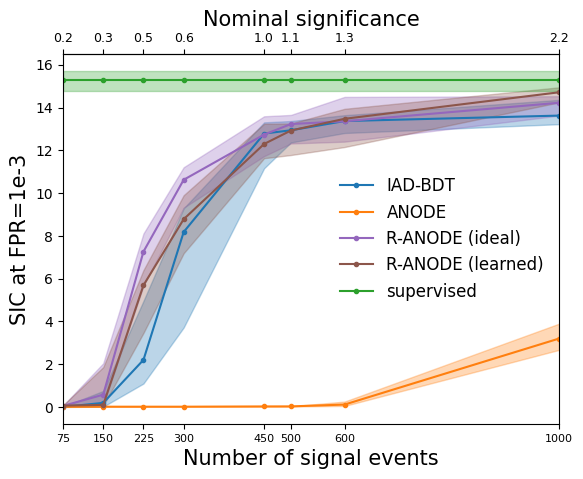

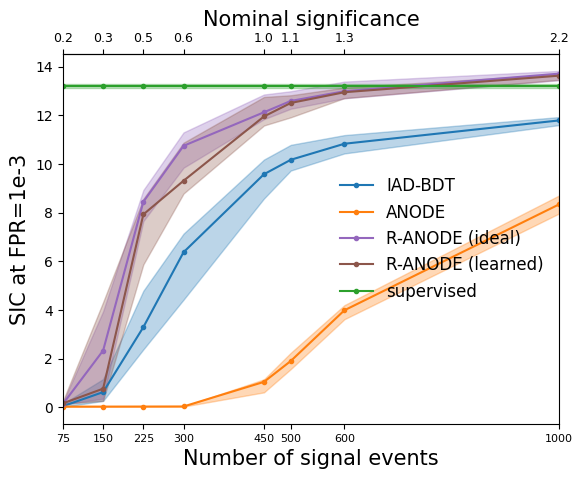

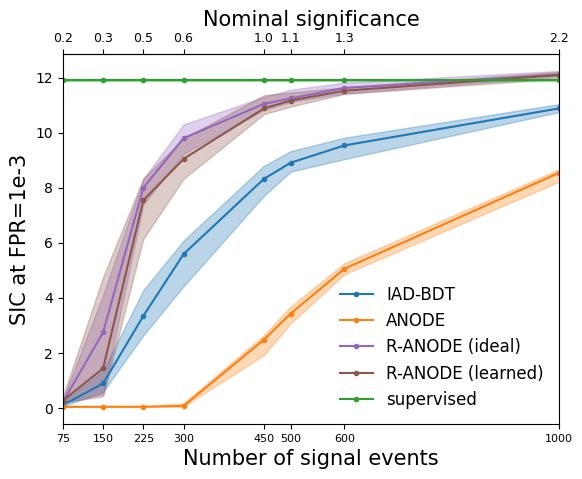

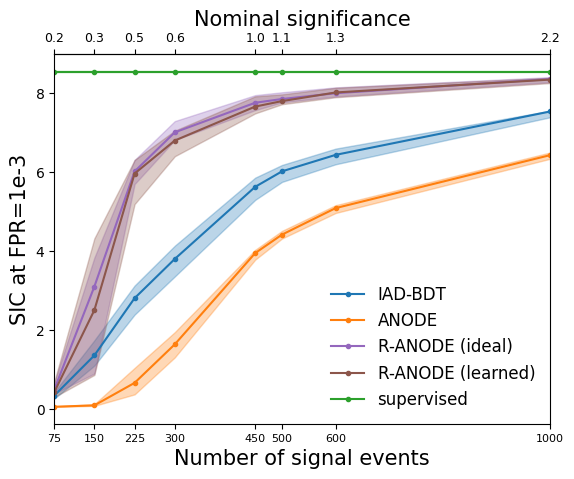

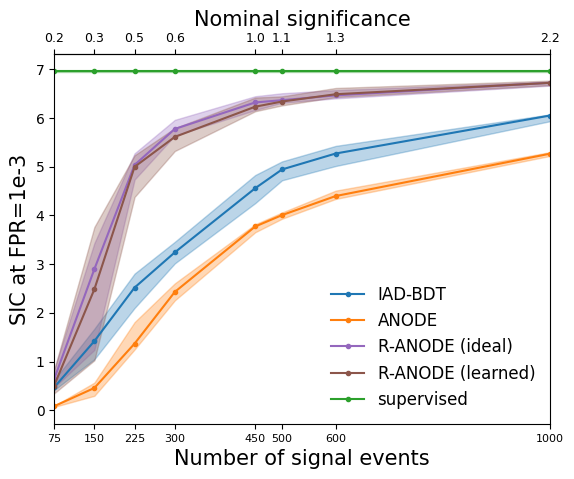

In [31]:

names = ['IAD-BDT','ANODE','R-ANODE_true','R-ANODE_learned','supervised']
legend_names = ['IAD-BDT','ANODE','R-ANODE (ideal)','R-ANODE (learned)','supervised']
colors = ['C0','C1','C4','C5','C2']

# the index is for fprs
for index in range(5):
    fig = plt.figure()
    #botax = plt.gca()
    ax = fig.add_subplot(111)

   # topax = botax.twiny()
    for legend_index,name in enumerate(names):

        _min_sic = []
        _max_sic = []
        _median_sic = []

        _min_sig = []
        _max_sig = []
        _median_sig = []

        for k,nsig in enumerate(nsigs):

            if k!=0 and name=='supervised':
                _min_sic.append(sic_min)
                _max_sic.append(sic_max)
                _median_sic.append(sic)

                _min_sig.append(sic_min*sigmas[k])
                _max_sig.append(sic_max*sigmas[k])
                _median_sig.append(sic*sigmas[k])
                continue

            sic_min = sic_dict[nsig][f'{name}_min'][index]
            sic_max = sic_dict[nsig][f'{name}_max'][index]
            sic = sic_dict[nsig][name][index]

            

            _min_sic.append(sic_min)
            _max_sic.append(sic_max)
            _median_sic.append(sic)

            _min_sig.append(sic_min*sigmas[k])
            _max_sig.append(sic_max*sigmas[k])
            _median_sig.append(sic*sigmas[k])

        _min_sic = np.array(_min_sic)
        _max_sic = np.array(_max_sic)
        _median_sic = np.array(_median_sic)

        _min_sig = np.array(_min_sig)
        _max_sig = np.array(_max_sig)
        _median_sig = np.array(_median_sig)



        plt.plot(nsigs, _median_sic, marker=".", 
        label=legend_names[legend_index],color = colors[legend_index])
        plt.fill_between(nsigs, _min_sic, _max_sic, alpha=0.3,color = colors[legend_index])


    plt.xlabel('Number of signal events',fontsize=15)
    plt.ylabel(f'SIC at FPR=1e-3',fontsize=15)
   # ax.set_ticks_position('bottom')
    ax.set_xticks(np.array(nsigs))
    ax.set_xticklabels(np.array(nsigs), fontsize=8)

    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xlabel('Nominal significance',fontsize=15)
    ax_t.set_xticks(np.array(nsigs))
    ax_t.set_xticklabels(np.round(sigmas,decimals=1), fontsize=9)
  #  topax.xaxis.set_ticks_position('top')
  #  topax.set_xticks(np.array(nsigs))
  #  topax.set_xticklabels(np.round(sigmas,decimals=1), fontsize=9)
    # plt.title(f'FPR={fpr_interp[index]}', fontsize=15)
    plt.legend(frameon=False, fontsize=12)
    plt.savefig(f'./figures/SIC_at_fpr_{fpr_interp[index]}.pdf',dpi=200)
    plt.xlim(75,1000)
    plt.show()



5.316182
0.0064990000000000004
6.903562750000001
5.706122


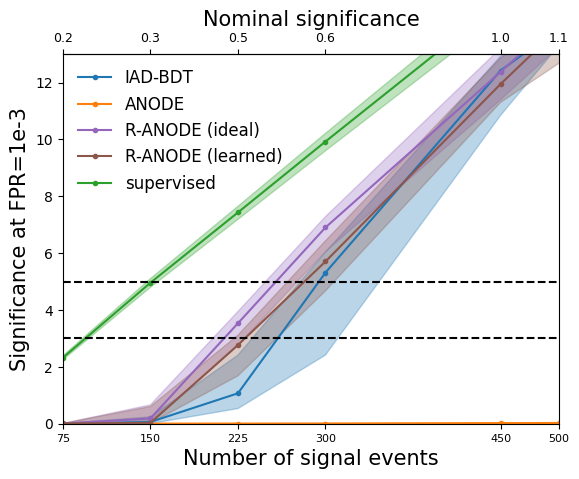

4.142405259234062
0.02397813954652237
6.98272488006303
6.050483878905811


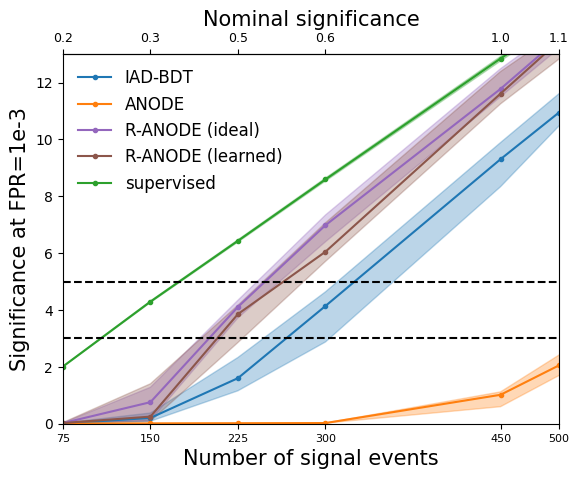

3.630961441061005
0.045727404592391316
6.367926432787618
5.878797340967882


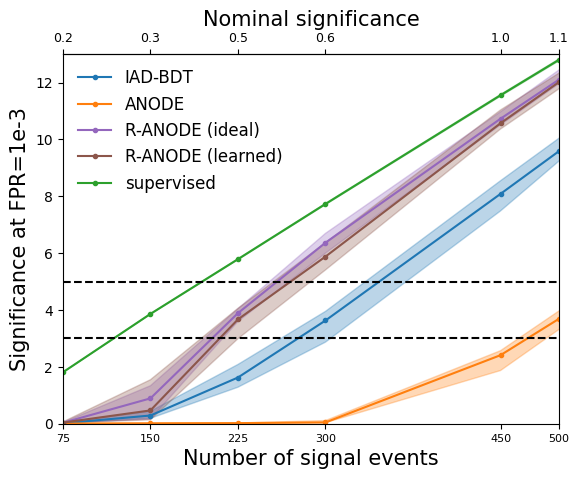

2.4732910877552645
1.0686804950900906
4.555736008632816
4.421088240384527


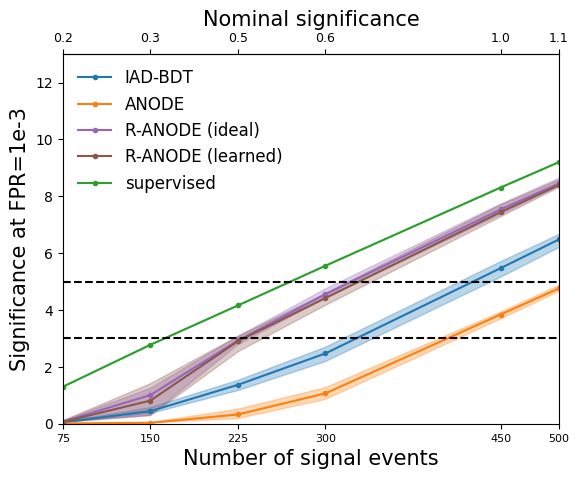

2.10665085
1.578769575
3.7533349750000005
3.647076325


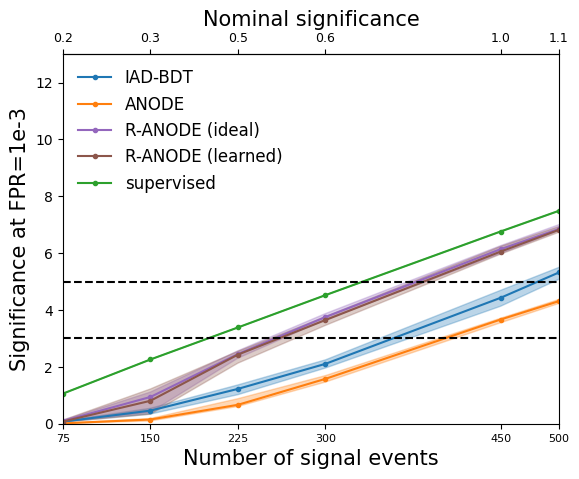

In [32]:

names = ['IAD-BDT','ANODE','R-ANODE_true','R-ANODE_learned','supervised']
legend_names = ['IAD-BDT','ANODE','R-ANODE (ideal)','R-ANODE (learned)','supervised']
colors = ['C0','C1','C4','C5','C2']


for index in range(5):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for name_index,name in enumerate(names):

        _min_sic = []
        _max_sic = []
        _median_sic = []

        _min_sig = []
        _max_sig = []
        _median_sig = []

        for k,nsig in enumerate(nsigs):

            if k!=0 and name=='supervised':
                _min_sic.append(sic_min)
                _max_sic.append(sic_max)
                _median_sic.append(sic)

                _min_sig.append(sic_min*sigmas[k])
                _max_sig.append(sic_max*sigmas[k])
                _median_sig.append(sic*sigmas[k])
                continue

            sic_min = sic_dict[nsig][f'{name}_min'][index]
            sic_max = sic_dict[nsig][f'{name}_max'][index]
            sic = sic_dict[nsig][name][index]

            _min_sic.append(sic_min)
            _max_sic.append(sic_max)
            _median_sic.append(sic)

            _min_sig.append(sic_min*sigmas[k])
            _max_sig.append(sic_max*sigmas[k])
            _median_sig.append(sic*sigmas[k])

            if nsig==300:
                print(sic*sigmas[k])

        _min_sic = np.array(_min_sic)
        _max_sic = np.array(_max_sic)
        _median_sic = np.array(_median_sic)

        _min_sig = np.array(_min_sig)
        _max_sig = np.array(_max_sig)
        _median_sig = np.array(_median_sig)



        plt.plot(nsigs, _median_sig, marker=".", label=legend_names[name_index],
                 color=colors[name_index])
        plt.fill_between(nsigs, _min_sig, _max_sig, alpha=0.3, color=colors[name_index])


   # plt.plot(nsigs, sigmas, marker=".", label=r'$S/\sqrt{B}$')
    plt.xlabel('Number of signal events',fontsize=15)
    plt.ylabel('Significance at FPR=1e-3',fontsize=15)
    plt.axhline(5,linestyle='--',color='black')
    plt.axhline(3,linestyle='--',color='black')
    ax.set_xticks(np.array(nsigs))
    ax.set_xticklabels(np.array(nsigs), fontsize=8)

    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xlabel('Nominal significance',fontsize=15)
    ax_t.set_xticks(np.array(nsigs))
    ax_t.set_xticklabels(np.round(sigmas,decimals=1), fontsize=9)
   # plt.title(f'FPR={fpr_interp[index]}', fontsize=15)
    plt.xlim(75,500)
    plt.ylim(0,13)
    plt.legend(frameon=False, fontsize=12, loc = 'upper left')
    plt.savefig(f'./figures/sig_at_fpr_{fpr_interp[index]}.pdf',dpi=200)

    plt.show()



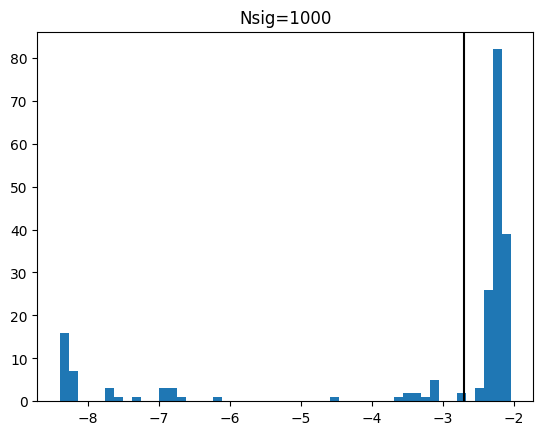

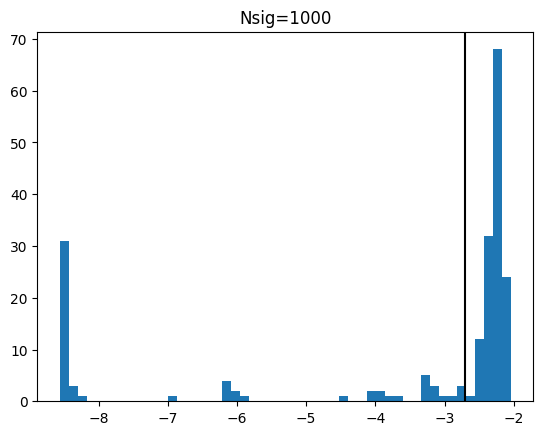

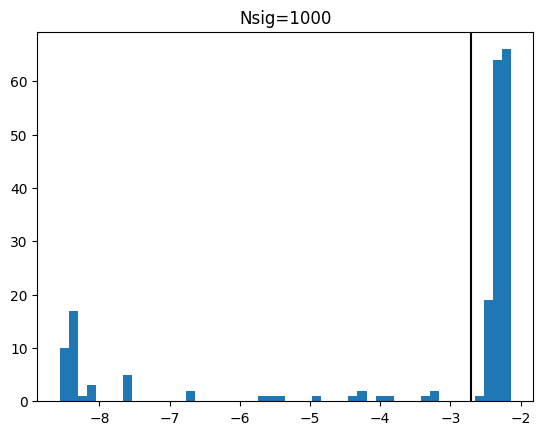

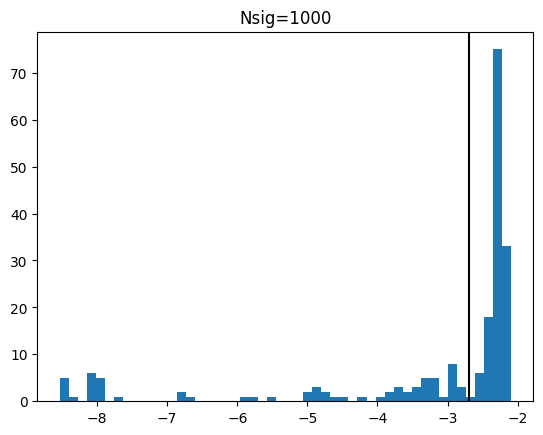

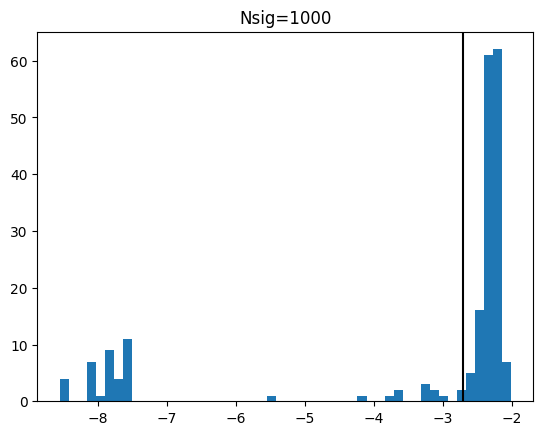

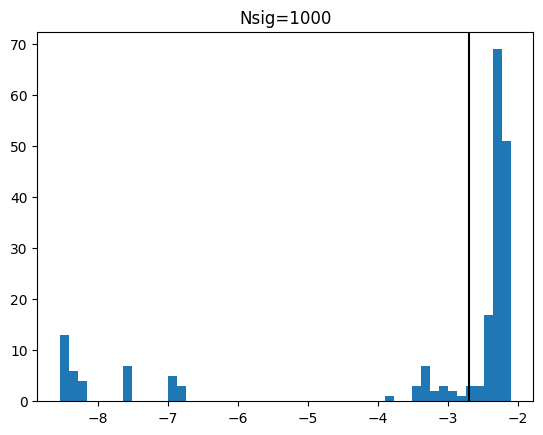

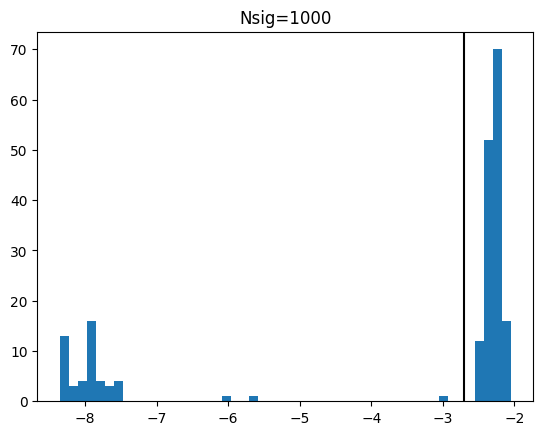

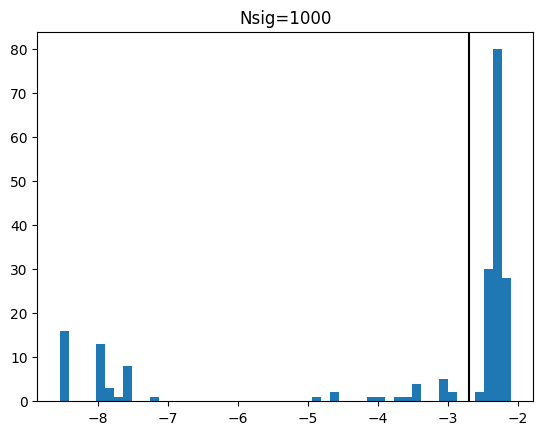

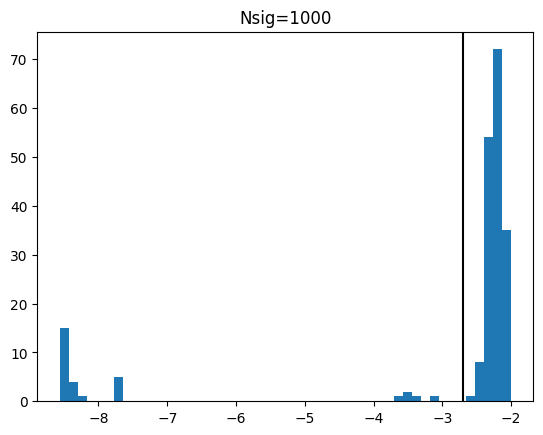

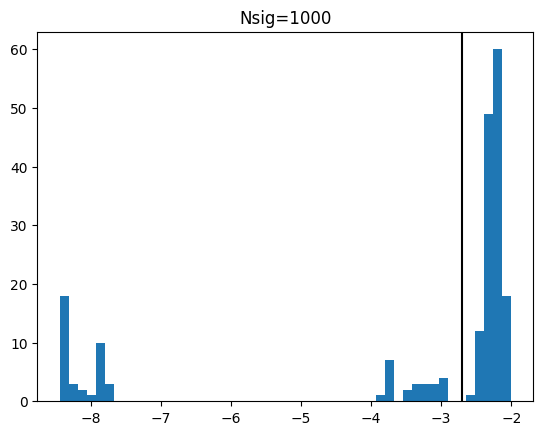

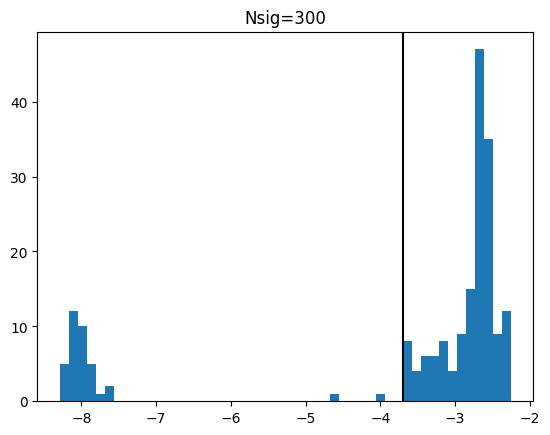

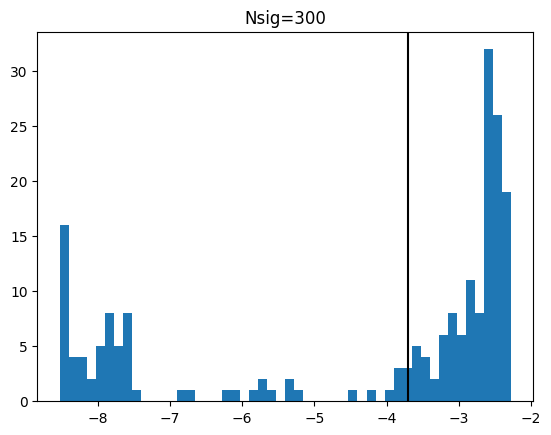

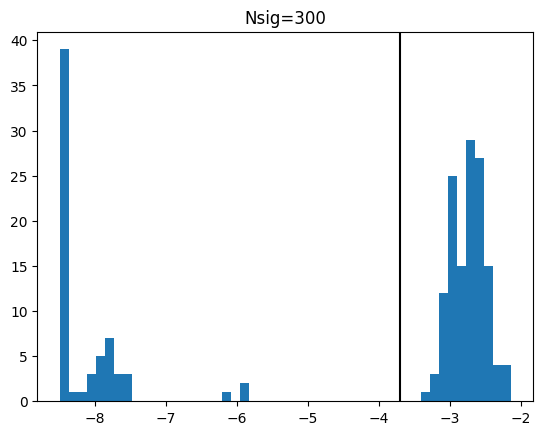

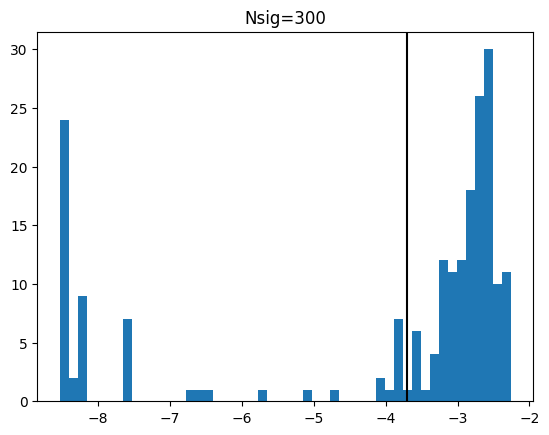

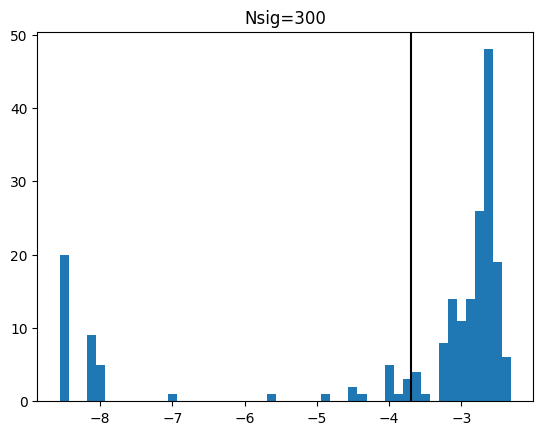

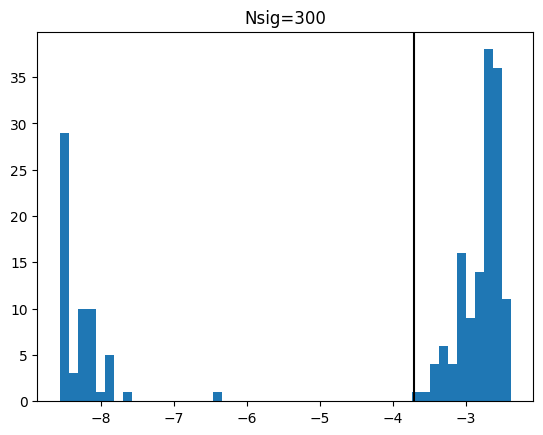

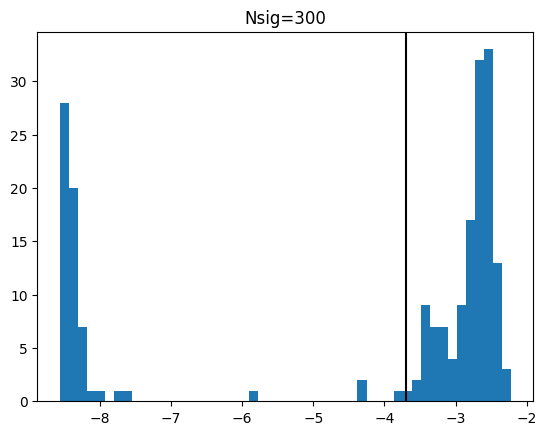

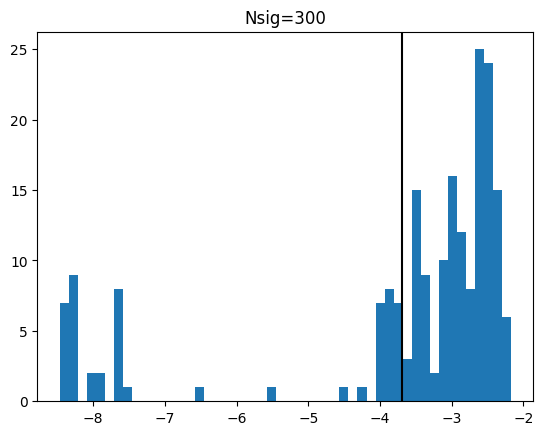

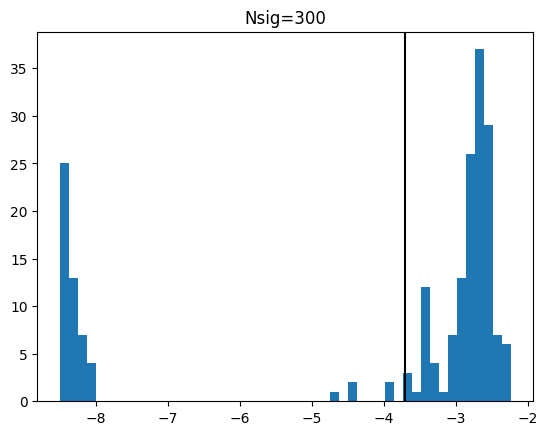

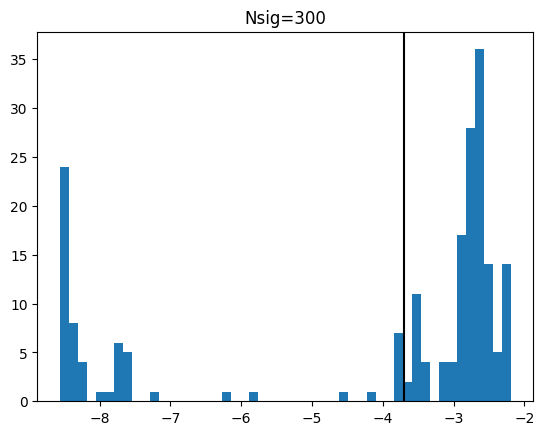

In [18]:


for nsig in nsigs:
    for i in range(10):
        w_ensemble = []
        for ensembles in range(20):
            valloss = np.load(f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_{ensembles}/valloss.npy')
            lowest_epochs = np.argsort(valloss)[0:10]
            for epoch in lowest_epochs:
                w_ = np.load(f'results/{wandb_group_ranode_pdata}/{wandb_project_ranode_pdata}_{nsig}/{wandb_job_type_ranode_pdata}_{i}_{ensembles}/w_{epoch}.npy')
                w_ensemble.append(w_)

        w_ensemble = np.array(w_ensemble)
        plt.hist(np.log10(w_ensemble), bins=50)
        plt.title(f'Nsig={nsig}')
        plt.axvline(np.log10(cuts[nsig][i]), color='black')
        plt.show()
    #w_ensemble = np.array(w_ensemble)
    #w_median = np.median(w_ensemble, axis=0)
    #w_try.append(w_median)

In [19]:
_median_sic_RANODE_pdata

[14.920442352691827, 10.62362847787554, 14.920442352691827, 10.62362847787554]

In [20]:
_max_sic_RANODE_pdata

NameError: name '_max_sic_RANODE_pdata' is not defined